# Flow directions and Flow Accumulation

Flow direction calculations are the basis for accumulating the upslope contributing area (flow accumulation) for each cell in a grid or on a raster. Traditional methods assume a Structured 8-neighbor grid, such as a raster, for doing these calculations. The D-Any package breaks away from that model and can perform calculations for any number of nearest neighbors to a given cell. 

Flow dirctions, flow accumulation, and a number of other calculations like slope and aspect can be performed with D-Any's `FlowDirections` class. 

In this example, we'll set up a structured grid and a voronoi mesh to explore the `FlowDirections` class

In [1]:
import os
import dany
import flopy
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
from dataretrieval import nwis

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

epsg_wgs = 4326  # decimal lat lon
epsg_utm = 26911  # NAD83 UTM Zone 11 N

### Structured grid example

In this example, a structured grid will be created from the boundaries of a Digital Elevation Model (DEM) raster. The resultant grid will be used to resample the raster, calculate flow directions and flow accumulation values, and define an catchment (basin). 

Load the raster to begin

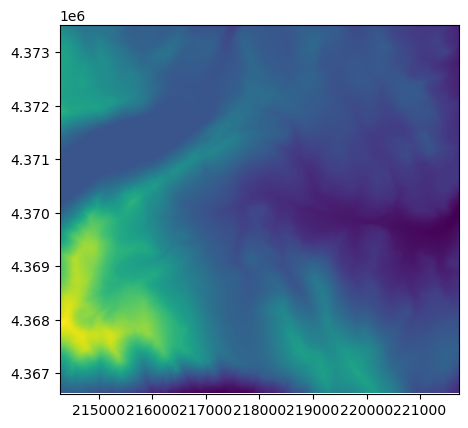

In [2]:
raster = pl.Path("../data/dem.img")

rstr = flopy.utils.Raster.load(raster)
rstr.to_crs(epsg=epsg_utm, inplace=True)
rstr.plot();

Get information about the raster to generate the structured grid

In [3]:
xmin, xmax, ymin, ymax = rstr.bounds
crs = rstr.crs

Build the grid

In [4]:
dx = 150
dy = 150
nlay = 1
ncol = int(np.floor((xmax - xmin) / dx))
nrow = int(np.floor((ymax - ymin) / dy))
delr = np.full((ncol,), dx)
delc = np.full((nrow,), dy)
top = np.ones((nrow, ncol))
botm = np.zeros((nlay, nrow, ncol))
idomain = np.ones(botm.shape, dtype=int)

sgrid = flopy.discretization.StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xoff=xmin,
    yoff=ymin,
    crs=crs
)

Resample the raster to the grid. For more information about this see:
   - [FloPy raster intersection](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)
   - [Structured_and_quadtree_meshes_from_existing_raster](Structured_and_quadtree_meshes_from_existing_raster.ipynb)
   - [Complex_meshes_from_existing_boundary](Complex_meshes_from_existing_boundary.ipynb)

In [5]:
dem = rstr.resample_to_grid(sgrid, band=rstr.bands[0], method="min")
dem[dem == rstr.nodatavals[0]] = np.nan

Hydrologically condition the resampled dem

In [6]:
dem = dany.fill_nan_values(sgrid, dem, method="mean")
conditioned_dem = dany.fill_sinks(sgrid, dem, eps=2e-06)

## Flow direction calculation on a structured grid

The `FlowDirections` class is used to calculate flow directions and other derived information that requires a set of hydrologic flow directions. The class is instantiated with the following parameters:
   - `modelgrid`: flopy.discretization.Grid object, FlowDirections supports FloPy's StructuredGrid (DIS), VertexGrid (DISV), and UnstructuredGrid (DISU) objects
   - `dem`: numpy array of resampled DEM elevations
   - `check_elevations`: boolean flag that asserts that there is a single unique minimum elevation in the DEM, default is False.

In [7]:
fdobj = dany.FlowDirections(sgrid, conditioned_dem)

### Calculate flow directions
The `flow_directions()` method on the `FlowDirections()` class is used to calculate flow directions. The `flow_directions()` method has one optional input parameter:
   - `burn_threshold`: float. This is a digital threshold for handling small numerical artifacts in the resampled DEM. Upslope differences between neighboring elevations within this digital threshold will be considered digitally flat (slope = 0). The default value is 1e-6.

In [8]:
flow_dirs = fdobj.flow_directions()

Once flow directions are calculated, the user can get the array without re-calculating flow directions by calling `flow_direction_array`

In [9]:
flow_dirs = fdobj.flow_direction_array

Flow direction vector components can be returned to the user for plotting by calling `fdobj.vectors`

In [10]:
ux, uy = fdobj.vectors

### Calculate flow accumulation
Flow accumulation is calculated using the number of input drainage paths (NIDP) algorithm and accumulated as either the upslope contributing area or as the number of upslope contributing cells. The `flow_accumulation()` method has a single optional parameter:
   - `as_cells`: boolean, Defaults to False. If True return the upslope contributing area as the number of upslope contributing cells. This can be useful for structured grids with uniform cell sizes. Default is False and will return the upslope contributing area as an upslope area, which is preferred for grids that have non-uniform cell sizes.

Because the structured grid here has a uniform cell size, this example will use `as_cells=True`. *If row or column spacing was not uniform, the default (`as_cells=False`) will give a more accurate flow accumulation calculation.*

In [11]:
flow_acc = fdobj.flow_accumulation(as_cells=True)

#### Plot flow direction vectors and flow accumulation



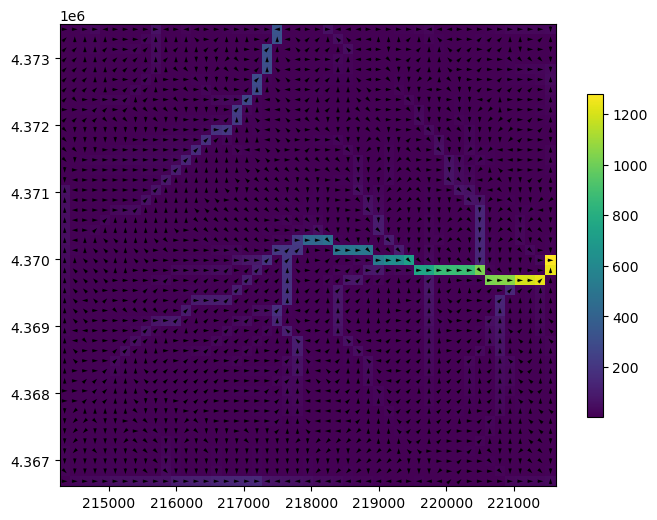

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(flow_acc)
pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7);

### Basin and sub-bassin delineation

The `FlowDirections` class has methods for watershed and subbasin delineation. The first method `get_watershed_boundary()` uses information from the computed flow directions to determine the digital divides in the basin. The `get_watershed_boundary()` method has one parameter:
   - `point`: geospatial object, point can be any of the following objects:
      - (x, y) coordinate pair
      - shapefile.Shape object
      - flopy.utils.geometry.Point object
      - geojson Point object
      - shapely Point object.

In this example, stream gage locations will be downloaded from NWIS and used as the pour point for the basin.

In [13]:
# get the bounding box of the grid in decimal lat, lon
gdf = sgrid.geo_dataframe
gdf = gdf.to_crs(epsg=epsg_wgs)
gdf = gdf.dissolve()
bBox = [f"{i :.2f}" for i in gdf.bounds.values[0]]

# put data into geodataframe for plotting and examining
info, metadata = nwis.get_info(bBox=bBox)
info = info[info.site_tp_cd == "ST"]
info.to_crs(epsg=epsg_utm, inplace=True)
info.head()

agency_cd          site_no                                   station_nm  \
1      USGS         10343000                 INDEPENDENCE C NR TRUCKEE CA   
2      USGS         10343500                      SAGEHEN C NR TRUCKEE CA   
3      USGS  392501120182800             SAGEHEN CR NR CARPENTER RIDGE CA   
5      USGS  392558120152000       PRE-CAMPGROUND TRIB NR HOBART MILLS CA   
6      USGS  392558120152100  SAGEHEN CR AB CAMPGROUND NR HOBART MILLS CA   

  site_tp_cd    lat_va    long_va  dec_lat_va  dec_long_va coord_meth_cd  \
1         ST  392724.0  1201710.0   39.456572  -120.287148             M   
2         ST  392554.0  1201413.0   39.431572  -120.237979             M   
3         ST  392501.0  1201828.0   39.416849  -120.308814             M   
5         ST  392558.0  1201520.0   39.432683  -120.256591             M   
6         ST  392558.0  1201521.0   39.432683  -120.256868             M   

  coord_acy_cd  ... reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  \
1            F  ...            NaN   NNNNNNNN          NaN      NaN   
2            F  ...            NaN   NNNNNNNN          NaN      NaN   
3            S  ...            NaN   NNNNNNNN          NaN      NaN   
5            S  ...            NaN   NNNNNNNN          NaN      NaN   
6            S  ...            NaN   NNNNNNNN          NaN      NaN   

   aqfr_type_cd well_depth_va hole_depth_va depth_src_cd  project_no  \
1           NaN           NaN           NaN          NaN         NaN   
2           NaN           NaN           NaN          NaN         NaN   
3           NaN           NaN           NaN          NaN         NaN   
5           NaN           NaN           NaN          NaN         NaN   
6           NaN           NaN           NaN          NaN         NaN   

                         geometry  
1  POINT (217168.338 4372603.864)  
2  POINT (221299.997 4369675.311)  
3  POINT (215141.782 4368262.355)  
5  POINT (219702.187 4369856.371)  
6  POINT (219678.280 4369857.235)  

[5 rows x 43 columns]

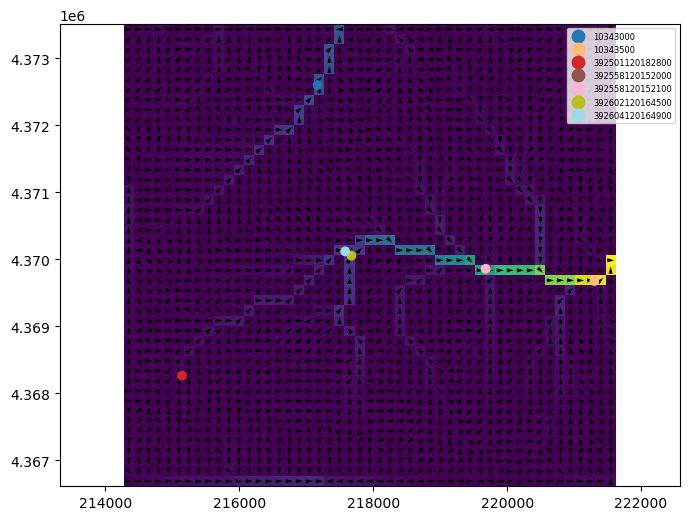

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(flow_acc)
v = pmv.plot_vector(ux, uy)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

Get the watershed boundary mask using USGS stream gage station 10343500 as the basin outlet

In [15]:
watershed = fdobj.get_watershed_boundary(info.geometry.values[1])

Use the watershed as a mask for plotting

In [16]:
flow_acc[watershed == 0] = np.nan
ux[watershed.ravel() == 0] = np.nan
uy[watershed.ravel() == 0] = np.nan

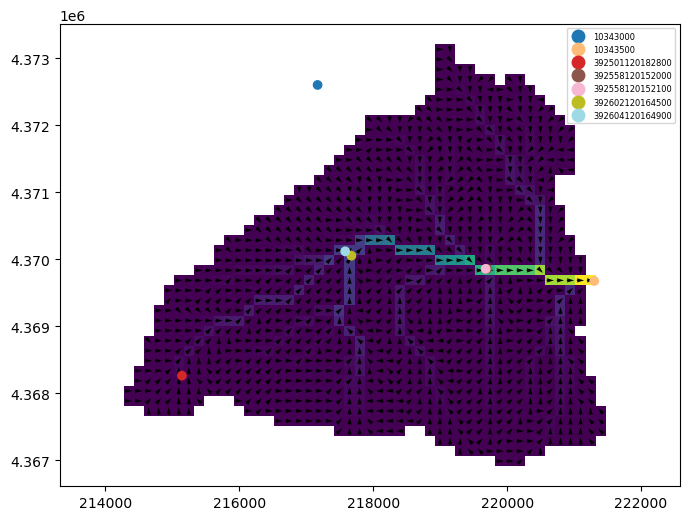

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(flow_acc)
v = pmv.plot_vector(ux, uy)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

#### Define subbasins

The method `get_subbasins` can be used to define different subbasins within a watershed. The `get_subbasins` method takes a single input:
   - `points`: points is an iterable or collection object of supported point objects. Please see the documentation for `get_watershed_boundary` for the supported point types.

In [18]:
subbasins = fdobj.get_subbasins(info.geometry.values[1:])

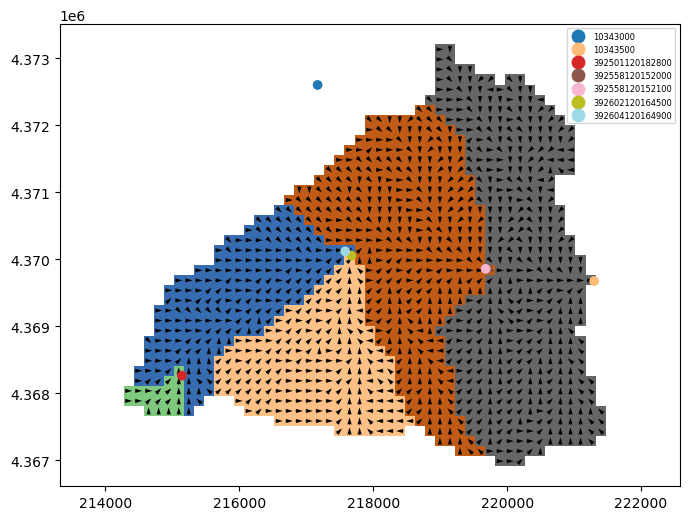

In [19]:
# plot the subbasins
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(subbasins, masked_values=[0,], cmap="Accent")
v = pmv.plot_vector(ux, uy)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

#### Get slope and aspect for each cell

The `FlowDirections` class has built in methods to calculate slope and aspect for each cell. These values can be accessed using the `slope` and `aspect` parameter methods.

In [20]:
slope = fdobj.slope
slope[watershed == 0] = np.nan

In [21]:
aspect = fdobj.aspect
aspect[watershed == 0] = np.nan

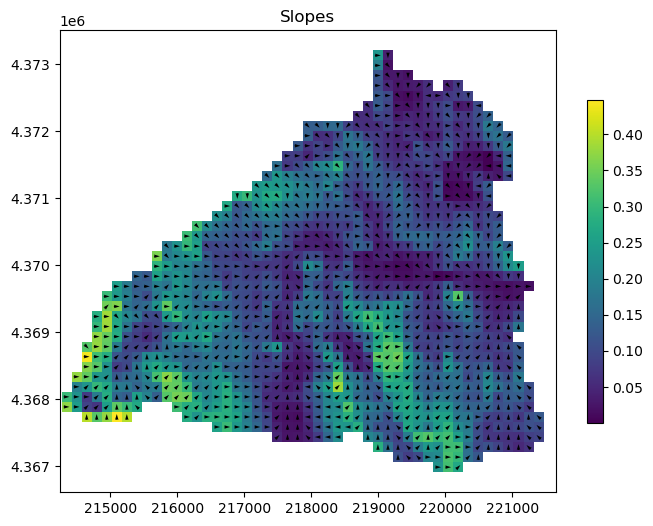

In [22]:
# plot the slopes
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(slope)
v = pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7)
plt.title("Slopes");

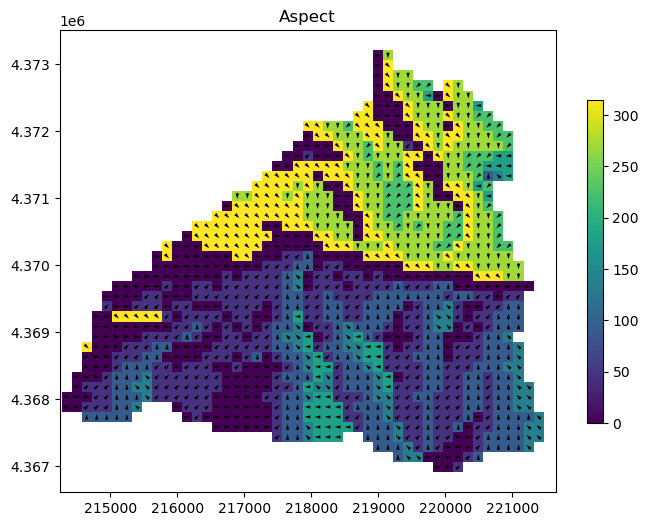

In [23]:
# plot the slopes
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(aspect)
v = pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7)
plt.title("Aspect");

## Voronoi mesh example

This example will apply flow direction calculations and flow accumulation calculations to a Voronoi grid. This example takes advantage of D-Any's any number of neighbors approach to calculate flow directions for an irregular grid. 

This example starts by creating a voronoi grid from the existing structured grid

In [24]:
griddf = sgrid.geo_dataframe

<Axes: >

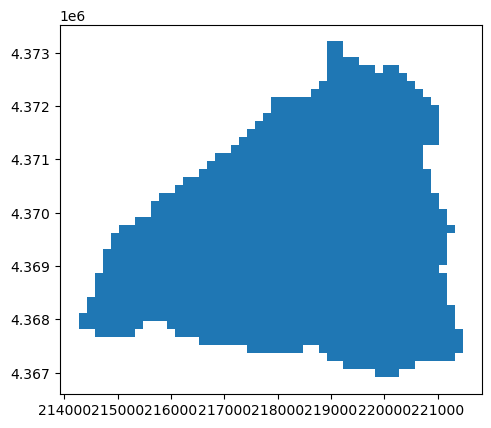

In [25]:
# get only the active watershed
griddf["active"] = watershed.ravel()
griddf = griddf[griddf.active > 0]
griddf.plot()

In [26]:
# dissolve the active cells into a single polygon
basindf = griddf.dissolve()
basin_poly = basindf.geometry.values[0]
basin_centroid = basindf.centroid.values[0]

Now create a triangular mesh from the basin polygon

In [27]:
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
ws = pl.Path("./fd_sh_tri")
ws.mkdir(exist_ok=True)

tri = Triangle(angle=30, model_ws=ws)

Add the boundary polygon and define it as a region

In [28]:
tri.add_polygon(basin_poly)
tri.add_region(basin_centroid, 0, maximum_area=4000)

Build the triangular mesh

In [29]:
tri.build()

Build the voronoi mesh

In [30]:
vor = VoronoiGrid(tri)
vgrid = flopy.discretization.VertexGrid(nlay=1, **vor.get_gridprops_vertexgrid())

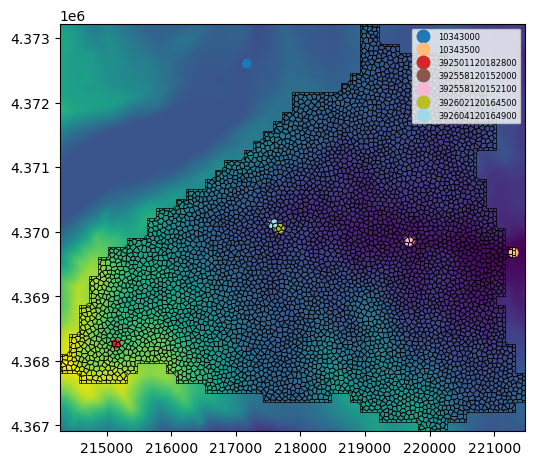

In [31]:
# plot the grid
fig, ax = plt.subplots(figsize=(6, 6))

rstr.plot(ax=ax)
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pmv.plot_grid(color="k", lw=0.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

#### Resample the DEM to the voronoi model grid

In [32]:
rstr = flopy.utils.Raster.load(raster)
rstr.to_crs(epsg=epsg_utm, inplace=True)
dem = rstr.resample_to_grid(vgrid, band=rstr.bands[0], method="min")
dem[dem == rstr.nodatavals[0]] = np.nan

Hydrologically condition the resampled dem


In [33]:
dem = dany.fill_nan_values(vgrid, dem, method="mean")
conditioned_dem = dany.fill_sinks(vgrid, dem, eps=2e-06)

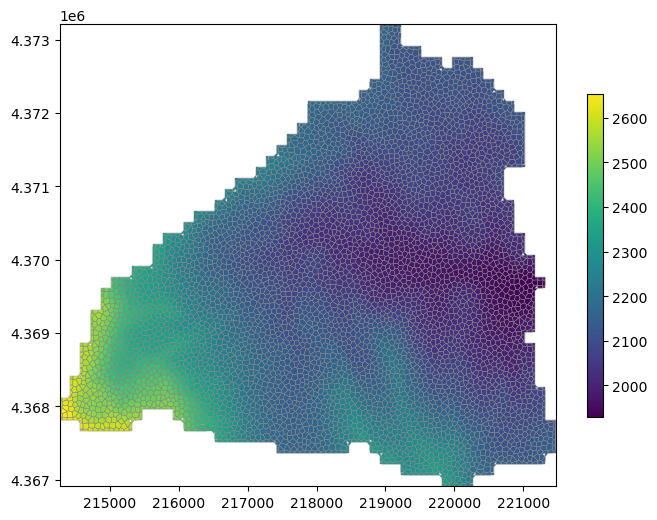

In [34]:
# plot the resampled and conditioned DEM

fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(conditioned_dem)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

## Flow direction calculation on a voronoi grid

The `FlowDirections` class is used to calculate flow directions and other derived information that requires a set of hydrologic flow directions. The class works identically for Structured, Vertex, and Unstructured Grids. The class is instantiated with the following parameters:
   - `modelgrid`: flopy.discretization.Grid object, FlowDirections supports FloPy's StructuredGrid (DIS), VertexGrid (DISV), and UnstructuredGrid (DISU) objects
   - `dem`: numpy array of resampled DEM elevations
   - `check_elevations`: boolean flag that asserts that there is a single unique minimum elevation in the DEM, default is False.

In [35]:
fdobj = dany.FlowDirections(vgrid, conditioned_dem)

### Calculate flow directions
The `flow_directions()` method on the `FlowDirections()` class is used to calculate flow directions. The `flow_directions()` method has one optional input parameter:
   - `burn_threshold`: float. This is a digital threshold for handling small numerical artifacts in the resampled DEM. Upslope differences between neighboring elevations within this digital threshold will be considered digitally flat (slope = 0). The default value is 1e-6.

In [36]:
flow_dir = fdobj.flow_directions()

### Calculate flow accumulation
Flow accumulation is calculated using the number of input drainage paths (NIDP) algorithm and accumulated as either the upslope contributing area or as the number of upslope contributing cells. The `flow_accumulation()` method has a single optional parameter:
   - `as_cells`: boolean, Defaults to False. If True return the upslope contributing area as the number of upslope contributing cells. This can be useful for structured grids with uniform cell sizes. Default is False and will return the upslope contributing area as an upslope area, which is preferred for grids that have non-uniform cell sizes.

In [37]:
flow_acc = fdobj.flow_accumulation()

#### Plot flow direction vectors and flow accumulation



In [38]:
ux, uy = fdobj.vectors

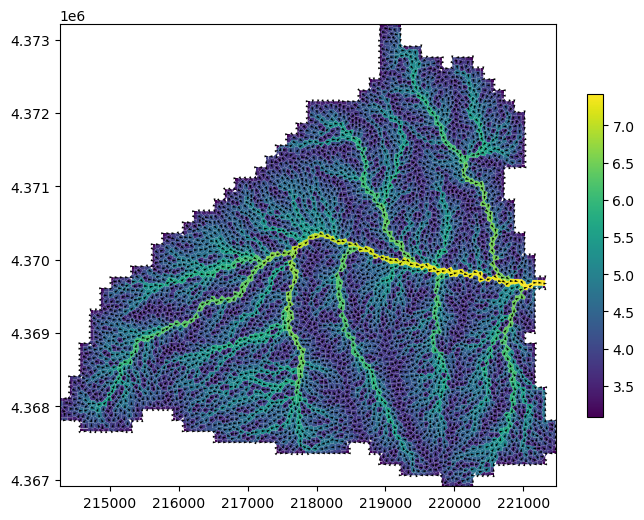

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(np.log10(flow_acc))
pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7);

#### Define subbasins

The method `get_subbasins` can be used to define different subbasins within a watershed. The `get_subbasins` method takes a single input:
   - `points`: points is an iterable or collection object of supported point objects. Please see the documentation for `get_watershed_boundary` for the supported point types.

In [40]:
# todo: maybe more debugging to speed the new calculation... We may need to spend more effort on "pre-ordering" the cells
# seems to be caught in an infinate loop currently....
subbasins = fdobj.get_subbasins(info.geometry.values[1:])

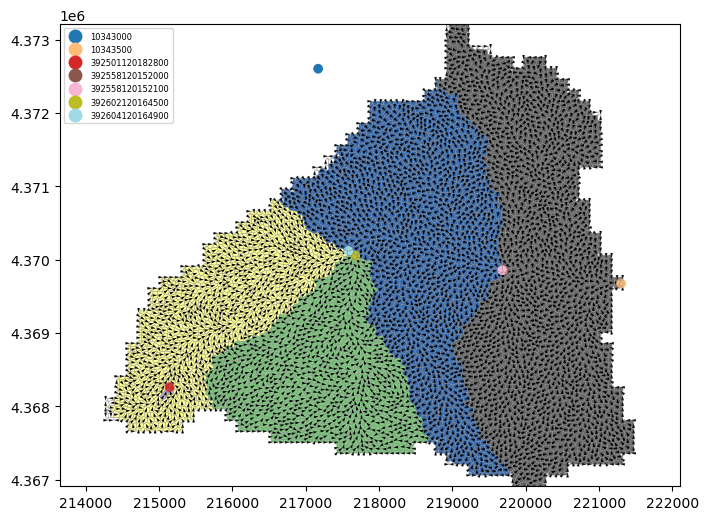

In [41]:
# plot the subbasins
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(subbasins, masked_values=[0,], cmap="Accent")
pmv.plot_grid(lw=0.2)
v = pmv.plot_vector(ux, uy)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

#### Get slope and aspect for each cell

The `FlowDirections` class has built in methods to calculate slope and aspect for each cell. These values can be accessed using the `slope` and `aspect` parameter methods.

In [42]:
slope = fdobj.slope
aspect = fdobj.aspect

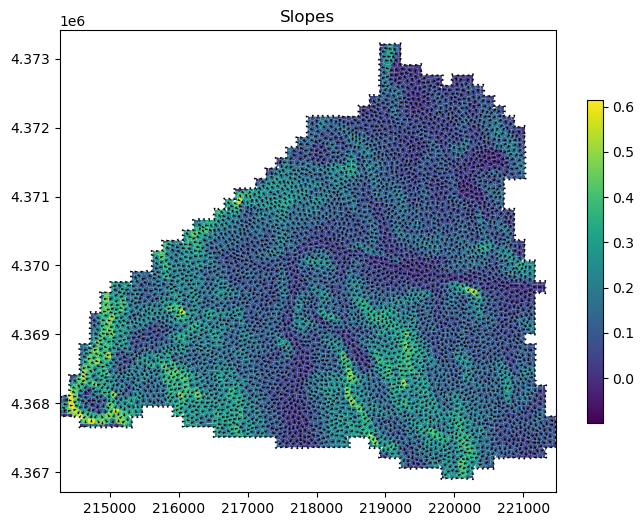

In [43]:
# plot the slopes
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(slope)
v = pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7)
plt.title("Slopes");

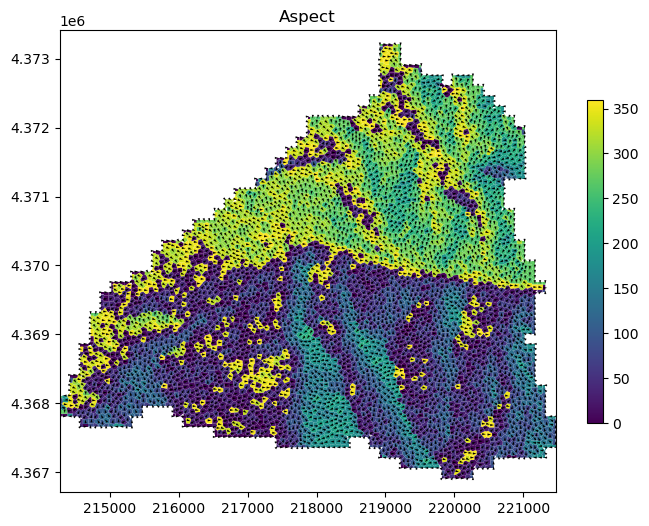

In [44]:
# plot the aspect
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(aspect)
v = pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7)
plt.title("Aspect");

#### Get the area for each cell
The `FlowDirections` class has a built in `area` property method. The `area` property uses the shoelace algorithm to calculate the area of each cell within a grid

In [45]:
area = fdobj.area

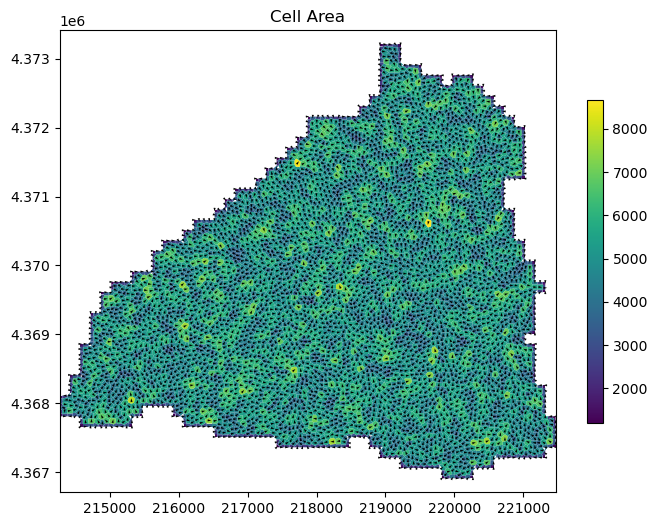

In [46]:
# plot the aspect
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(area)
v = pmv.plot_vector(ux, uy)
plt.colorbar(pc, shrink=0.7)
plt.title("Cell Area");

## Next steps

Once flow directions and flow accumulation has been calculated, stream delineation can be performed and information from these calculations can be used to build inputs to hydrologic models like PRMS, pywatershed, and MODFLOW. See the other notebook examples for this process